In [50]:
!pip install ipywidgets

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from IPython.display import display_markdown
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import streamlit as st
import seaborn as sns
import ipywidgets as widgets


In [51]:
# Default Year to start the prediction
year_to_start_prediction = 2022

# Default number of future years to predict
future_years = 7

features_set = ["Year", "Beef", "Sheep and goat", "Pork", "Other meats", "Fish and seafood", "Poultry"]

In [52]:
# Function to retrieve the population and meat consumption data and merge into a DataFrame
def get_data():
    population_df = pd.read_csv("https://ourworldindata.org/grapher/population.csv?country=USA~BRA~AUS~ESP~ZWE~MDV~JPN&v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
    meat_df = pd.read_csv("Consumption of meat per capita.csv")
    merged_df = pd.merge(population_df, meat_df, on=["Entity", "Year"], how="inner")
    return merged_df

In [53]:
# Initialize variables
future = future_years
year = year_to_start_prediction
meat_option = ""
plot_models = {}
countries_selected = []
ridge_best_performance = {}

In [54]:
widgets.IntText(
    value=7,
    description='Years to Predict:',
    disabled=False
)

IntText(value=7, description='Years to Predict:')

In [55]:
widgets.IntText(
    value=2021,
    description='Year to Start Prediction:',
    disabled=False
)

IntText(value=2021, description='Year to Start Prediction:')

In [56]:

widgets.Dropdown(
    options=features_set[1:len(features_set)],
    value=features_set[1],
    description='Meat Consumption Category:',
    disabled=False,
)

Dropdown(description='Meat Consumption Category:', options=('Beef', 'Sheep and goat', 'Pork', 'Other meats', '…

In [58]:
countries_list = get_data()['Entity'].unique()
widgets.Dropdown(
    options=countries_list,
    value=countries_list[0],
    description='Country to Predict:',
    disabled=False,
)

Dropdown(description='Country to Predict:', options=('Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua a…

In [6]:
# Function to filter and preepare the training data for prediction
def filter_and_prepare_training_data(df, column_to_filter, filter_value, X_column, Y_column):
    filtered_df = df[df[column_to_filter] == filter_value].copy()
    X = df[[X_column]].values
    Y = df[Y_column].values
    return filtered_df, X, Y

# Function to split the filtered data in a training and test sets
def split_into_training_and_test(X, Y, test_perc = 0.2, random_state_val = 42):
    # Split the data into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_val)
    return X_train, X_test, y_train, y_test

# Function to filter the combined DataFrame to a filtered DataFrame of target Countries
def filter_countries_by_names(data_frame, countries_list, country_column_name):
    filtered_df = data_frame[data_frame[country_column_name].isin(countries_list)]
    return filtered_df

In [7]:
# Function to calculate the performance metrics of a model
def calculate_metrics(y_values, prediction):
    metrics = {}
    mse_val = mean_squared_error(y_values, prediction)
    metrics["mse"] = mse_val
    metrics["rmse"] = np.sqrt(mse_val)
    metrics["mae"] = mean_absolute_error(y_values,prediction)
    metrics["r2"] = r2_score(y_values, prediction)
    return metrics

# Function to return the best Alpha score deteremined by GrandientCSV to use for the Ridge model
def get_ridge_best_score(X_train_scaled, y_train):
    
    # Define a range of alpha values to test
    alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    # Set up Ridge Regression and GridSearchCV
    ridge = Ridge()
    param_grid = {'alpha': alpha_values}

    # Perform Grid Search with 5-fold Cross-Validation
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=(len(alpha_values)+1), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best alpha value and the corresponding score
    best_alpha = grid_search.best_params_['alpha']
    mean_scores = -grid_search.cv_results_['mean_test_score']
    
    return best_alpha, mean_scores, alpha_values

In [8]:
# Function to combine the predicted population and meat production to the future years to a DataFrame
def get_combined_future_df(population_prediction, meat_prediction, years_list, meat_category):
    # Future Predicition
    predicted_data = []
    for year, pop, meat in zip(years_list, population_prediction, meat_prediction):
        predicted_data.append([year, pop, meat])
    
    return pd.DataFrame(predicted_data, columns=['Year', 'future_population', f'future_{meat_category}_consumption'])

# Function to filter out the meat consumption category that will be used to train the model for meat consumption
def get_meat_consumption_features(meat_category):
    features = []
   
    for feature in features_set:
        if feature != meat_category:
            features.append(feature)
    
    return features

# Function to create a future DataFrame to save the population and meat consumption predictions
def get_future_years_df(year_to_start_prediction, future_years):
    future_years_df = pd.DataFrame({
        "Year": np.arange(year_to_start_prediction, year_to_start_prediction + future_years), 
        "Beef": [0] * future_years,
        "Sheep and goat": [0] * future_years,
        "Pork": [0] * future_years,
        "Other meats": [0] * future_years,
        "Fish and seafood": [0] * future_years,
        "Poultry": [0] * future_years,
    })
    
    return future_years_df

In [9]:
# Function to plot the actual vs. the predicted values to determine training accuracy of a model
def plot_actual_vs_predicted(model_name, y_test, model_predictions, category):
    plt.scatter(y_test, model_predictions, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f"{model_name} Regression Actual vs Predicted for {category}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Function to plot the actual vs. predicted values for meat consumption
def plot_meat_prediction(df_pred, meat_category, country, year_start, year_end):
    # Plot the results
    # Plot the results
    ax = df_pred[['Year',f'future_{meat_category}_consumption']].plot(kind='bar', title =f'Predicted {meat_category} consumption per capita from {year_start} to {year_end}', legend=True, fontsize=16)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Future Consumption (per capita)", fontsize=12)
    plt.show()

# Function to plot the actual vs. predicted values for population
def plot_population_prediction(df_pred, country, year_start, year_end):
    # Plot the results
    ax = df_pred[['Year','future_population']].plot(kind='bar', title =f'Predicted {country} Population from {year_start} to {year_end}', legend=True, fontsize=16)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Future Population (millions)", fontsize=12)
    plt.show()

# Function to plot the Ridge best match scores determined by GradientCSV    
def plot_ridge_best_match(mean_scores, alpha_values, category):
    # Extract mean scores for each alpha
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_values, mean_scores, marker='o', linestyle='--', color='b')
    plt.xscale('log')  # Use log scale for alpha values
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Mean Cross-Validated MSE')
    plt.title(f'Grid Search Results: Alpha vs Mean Cross-Validated MSE for {category}')
    plt.grid(True)
    plt.show()

In [10]:
# Function to print the Population and Meat Consumption predictions for a model
def print_prediction(years_list,pop_predicted_df, meat_predicted_df, metrics_pop, metrics_meat, model_name):
    
    population_predictions = []
    meat_consumption_predictions = []
    
    
    for year, pop in zip(years_list, pop_predicted_df):
        #display(print(f"{year}: {pop:.2f}"))
        population_predictions.append(f"{year}: {pop:.2f}")
        
    
    for year, meat in zip(years_list, meat_predicted_df):
        #display(print(f"{year}: {meat:.2f}"))
        meat_consumption_predictions.append(f"{year}: {meat:.2f}")
    
    display(print(f"Population Predictions {model_name} (millions)"))    
    display(population_predictions)
    
    display(print(f"Meat Consumption Predictions {model_name} (kg per capita)"))
    display(meat_consumption_predictions)
      
    display(print("Population"))
    print_metrics(metrics_pop)
    display(print("Meat Consumption"))
    print_metrics(metrics_meat)
    
# Function to print the performance metrics for a model
def print_metrics(metrics_info):
    display(metrics_info)
    #display(print(f"MSE:</b> {metrics_info['mse']:.4f}"))
    #display(print(f"RMSE: {metrics_info['rmse']:.4f}"))
    #display(print(f"MAE: {metrics_info['mae']:.4f}"))
    #display(print(f"R2 Score:</b> {metrics_info['r2']:.4f}"))
    

In [11]:
# Function to train and predict the selected country and meat consumption category using the LinearRegression model
def train_and_predict_lr(df, country, country_column_name, population_column_name, year_column_name, meat_category, future_years=7):
    # Filter data for a specific Entity 
    country_entity = country  # Change this to the desired country
    country_entity_data = df[df[country_column_name] == country_entity]
    country_entity_data.fillna(0, inplace=True) 

    # Feature selection
    features = get_meat_consumption_features(meat_category)
    
    features_population = features_set 
    target_meat = meat_category
    target_population = population_column_name

    # Prepare features (X) and target (y)
    X = country_entity_data[features]
    y_meat = country_entity_data[target_meat]
    y_population = country_entity_data[target_population]

    # Split the data into training and testing sets
    X_train, X_test, y_meat_train, y_meat_test = train_test_split(X, y_meat, test_size=0.2, random_state=42)

    # Scale the meat consumption data
    meat_scaler = StandardScaler()
    X_train_scaled_meat = meat_scaler.fit_transform(X_train)
    X_test_scaled_meat = meat_scaler.transform(X_test)

    # Train Lasso Regression model for meat consumption
    lr_meat = LinearRegression()
    lr_meat.fit(X_train_scaled_meat, y_meat_train)

    # Evaluate the meat consumption model
    y_meat_pred = lr_meat.predict(X_test_scaled_meat)
    plot_models['linear_meat'] = {'prediction': y_meat_pred, 'y_test': y_meat_test}
    metrics_meat = calculate_metrics(y_meat_test, y_meat_pred)
    
    # Split the data into training and testing sets
    X = country_entity_data[features_population]
    X_train, X_test, y_population_train, y_population_test = train_test_split(X, y_population, test_size=0.2, random_state=42)

    # Scale the population data
    population_scaler = StandardScaler()
    X_train_scaled_population = population_scaler.fit_transform(X_train)
    X_test_scaled_population = population_scaler.transform(X_test)

    # Train Lasso Regression model for population
    lr_population = LinearRegression()
    lr_population.fit(X_train_scaled_population, y_population_train)
    
    # Evaluate the population model
    y_population_pred = lr_population.predict(X_test_scaled_population)
    plot_models['linear_population'] = {'prediction': y_population_pred, 'y_test': y_population_test}

    #st.write(f"No scaling for {population_column_name} Model MSE for {country}:", mean_squared_error(y_population_test, y_population_pred))
    #metrics_train_population, metrics_test_population = evaluate_model(lasso_population,X_train,X_test,y_population_train,y_population_test)
    metrics_pop = calculate_metrics(y_population_test, y_population_pred)
    
    future_years_population = get_future_years_df(year_to_start_prediction, future_years)
    
    # Scale future data
    future_years_scaled_population = population_scaler.transform(future_years_population)
    future_years_meat = future_years_population.drop(columns=[meat_category])
    future_years_scaled_meat = meat_scaler.transform(future_years_meat)    

    # Make predictions
    pop_predictions = lr_population.predict(future_years_scaled_population)
    meat_predictions = lr_meat.predict(future_years_scaled_meat)
    
    future_X = np.array(range(year_to_start_prediction, year_to_start_prediction + future_years)).reshape(-1, 1)
    
    return future_X.flatten(), pop_predictions, meat_predictions, metrics_pop, metrics_meat


In [12]:
# Function to train and predict the selected country and meat consumption category using the Lasso Regression model
def train_and_predict_lasso(df, country, country_column_name, population_column_name, year_column_name, meat_category, future_years=7):
    # Filter data for a specific Entity 
    country_entity = country  # Change this to the desired country
    country_entity_data = df[df[country_column_name] == country_entity]
    country_entity_data.fillna(0, inplace=True) 

    # Feature selection
    # Feature selection
    features = get_meat_consumption_features(meat_category)
    
    features_population = features_set
    target_meat = meat_category
    target_population = population_column_name

    # Prepare features (X) and target (y)
    X = country_entity_data[features]
    y_meat = country_entity_data[target_meat]
    y_population = country_entity_data[target_population]

    # Split the data into training and testing sets
    X_train, X_test, y_meat_train, y_meat_test = train_test_split(X, y_meat, test_size=0.2, random_state=42)

    # Scale the meat consumption data
    meat_scaler = StandardScaler()
    X_train_scaled_meat = meat_scaler.fit_transform(X_train)
    X_test_scaled_meat = meat_scaler.transform(X_test)

    # Train Lasso Regression model for meat consumption
    lasso_meat = Lasso(alpha=0.1)
    lasso_meat.fit(X_train_scaled_meat, y_meat_train)

    # Evaluate the meat consumption model
    y_meat_pred = lasso_meat.predict(X_test_scaled_meat)
    plot_models['lasso_meat'] = {'prediction': y_meat_pred, 'y_test': y_meat_test}
    
    metrics_meat = calculate_metrics(y_meat_test, y_meat_pred)
    
    # Split the data into training and testing sets
    X = country_entity_data[features_population]
    X_train, X_test, y_population_train, y_population_test = train_test_split(X, y_population, test_size=0.2, random_state=42)

    # Scale the population data
    population_scaler = StandardScaler()
    X_train_scaled_population = population_scaler.fit_transform(X_train)
    X_test_scaled_population = population_scaler.transform(X_test)

    # Train Lasso Regression model for population
    lasso_population = Lasso(alpha=0.1)
    lasso_population.fit(X_train_scaled_population, y_population_train)

    # Evaluate the population model
    y_population_pred = lasso_population.predict(X_test_scaled_population)
    plot_models['lasso_population'] = {'prediction': y_population_pred, 'y_test': y_population_test}

    metrics_pop = calculate_metrics(y_population_test, y_population_pred)
    
    # Predict for the next 10 years
    future_years_population = future_years_population = get_future_years_df(year_to_start_prediction, future_years)

    # Scale future data
    future_years_scaled_population = population_scaler.transform(future_years_population)
    future_years_meat = future_years_population.drop(columns=[meat_category])
    future_years_scaled_meat = meat_scaler.transform(future_years_meat)
    

    # Make predictions
    pop_predictions = lasso_population.predict(future_years_scaled_population)
    meat_predictions = lasso_meat.predict(future_years_scaled_meat)
    
    future_X = np.array(range(year_to_start_prediction, year_to_start_prediction + future_years)).reshape(-1, 1)

    return future_X.flatten(), pop_predictions, meat_predictions, metrics_pop, metrics_meat


In [13]:
# Function to train and predict the selected country and meat consumption category using the Ridge Regression model
def train_and_predict_ridge(df, country, country_column_name, population_column_name, year_column_name, meat_category, future_years=7):
   # Filter data for a specific Entity
    country_entity = country  # Change this to the desired country
    country_entity_data = df[df[country_column_name] == country_entity]
    country_entity_data.fillna(0, inplace=True) 
    

    # Feature selection
    # Feature selection
    features = get_meat_consumption_features(meat_category)
    
    features_population = features_set
    target_meat = meat_category
    target_population = population_column_name

    # Prepare features (X) and target (y)
    X = country_entity_data[features]
    y_meat = country_entity_data[target_meat]
    y_population = country_entity_data[target_population]

    # Split the data into training and testing sets
    X_train, X_test, y_meat_train, y_meat_test = train_test_split(X, y_meat, test_size=0.2, random_state=42)

    # Scale the meat consumption data
    meat_scaler = StandardScaler()
    X_train_scaled_meat = meat_scaler.fit_transform(X_train)
    X_test_scaled_meat = meat_scaler.transform(X_test)
    
    best_param, mean_scores, alpha_values = get_ridge_best_score(X_train_scaled_meat,y_meat_train)
    
       
    # Train Ridge Regression model for meat consumption
    r_meat = Ridge(alpha=best_param)
    r_meat.fit(X_train_scaled_meat, y_meat_train)
    
    ridge_best_performance['meat'] = {'best_param':best_param,'features':features, 'mean_scores': mean_scores, 'alpha_values':alpha_values}

    # Evaluate the meat consumption model
    y_meat_pred = r_meat.predict(X_test_scaled_meat)
    plot_models['ridge_meat'] = {'prediction': y_meat_pred, 'y_test': y_meat_test}
    
    metrics_meat = calculate_metrics(y_meat_test, y_meat_pred)
    
    # Split the data into training and testing sets
    X = country_entity_data[features_population]
    X_train, X_test, y_population_train, y_population_test = train_test_split(X, y_population, test_size=0.2, random_state=42)

    # Scale the population data
    population_scaler = StandardScaler()
    X_train_scaled_population = population_scaler.fit_transform(X_train)
    X_test_scaled_population = population_scaler.transform(X_test)

    best_param, mean_scores, alpha_values = get_ridge_best_score(X_train_scaled_population,y_population_train)
    
    # Train Lasso Regression model for population
    r_population = Ridge(alpha=best_param)
    r_population.fit(X_train_scaled_population, y_population_train)

    ridge_best_performance['population'] = {'best_param':best_param,'features':features_population, 'mean_scores': mean_scores, 'alpha_values':alpha_values}

    # Evaluate the population model
    y_population_pred = r_population.predict(X_test_scaled_population)
    plot_models['ridge_population'] = {'prediction': y_population_pred, 'y_test': y_population_test}

       
    metrics_pop = calculate_metrics(y_population_test, y_population_pred)
    
    # Predict for the next 10 years
    future_years_population = future_years_population = get_future_years_df(year_to_start_prediction, future_years)

    # Scale future data
    future_years_scaled_population = population_scaler.transform(future_years_population)
    future_years_meat = future_years_population.drop(columns=[meat_category])
    future_years_scaled_meat = meat_scaler.transform(future_years_meat)
    

    # Make predictions
    pop_predictions = r_population.predict(future_years_scaled_population)
    meat_predictions = r_meat.predict(future_years_scaled_meat)
    
    future_X = np.array(range(year_to_start_prediction, year_to_start_prediction + future_years)).reshape(-1, 1)

    return future_X.flatten(), pop_predictions, meat_predictions, metrics_pop, metrics_meat


In [14]:
df = get_data() #create_sample_data()
    
countries_to_pull = ['United States', 'Brazil', 'Australia', 'Spain', 'Zimbabwe', 'Maldives', 'Japan']
filtered_population_df = filter_countries_by_names(df, countries_to_pull, 'Entity')
meat_category = "Poultry"
future_X = np.array(range(year_to_start_prediction, year_to_start_prediction + future_years)).reshape(-1, 1)

country = countries_to_pull[0]

years, pop_pred, meat_pred, metrics_pop, metrics_meat = train_and_predict_lr(filtered_population_df, country, 'Entity', 'population_historical', 'Year', meat_category, future_years)
combined_future_df = get_combined_future_df(pop_pred,meat_pred,future_X,meat_category)



C:\Users\mark_\AppData\Local\Temp\ipykernel_26884\4240721066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_entity_data.fillna(0, inplace=True)


## Linear Regression Model Predictions

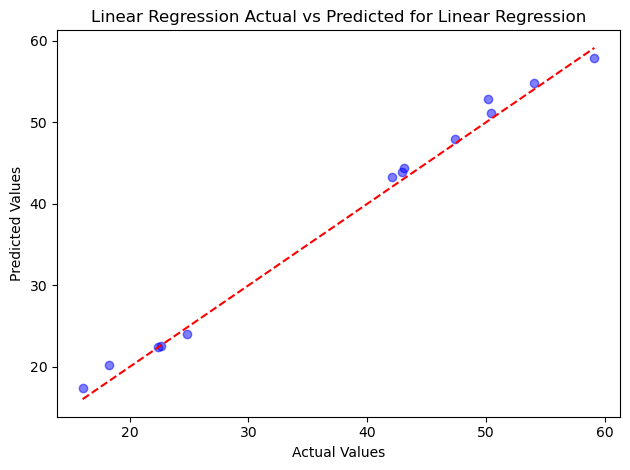

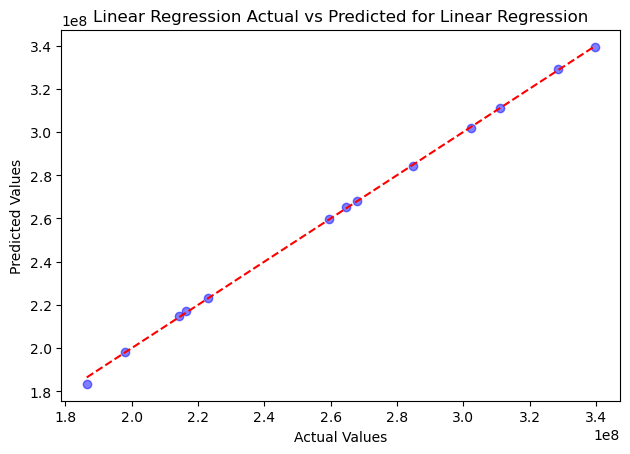

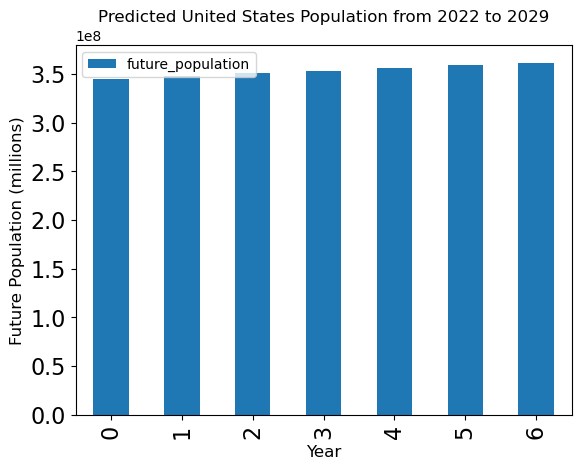

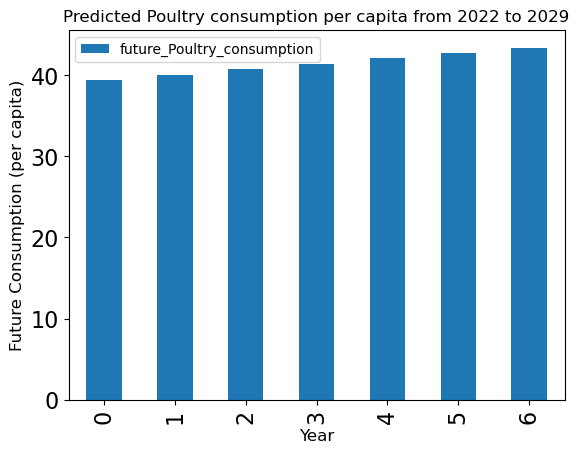

Population Predictions LinearRegression (millions)


None

['2022: 347134768.64',
 '2023: 349953279.33',
 '2024: 352771790.02',
 '2025: 355590300.71',
 '2026: 358408811.40',
 '2027: 361227322.09',
 '2028: 364045832.78']

Meat Consumption Predictions LinearRegression (kg per capita)


None

['2022: 39.43',
 '2023: 40.10',
 '2024: 40.77',
 '2025: 41.44',
 '2026: 42.11',
 '2027: 42.78',
 '2028: 43.45']

Population


None

{'mse': 939324345677.7449,
 'rmse': 969187.4667357935,
 'mae': 637855.2325250965,
 'r2': 0.999606125152725}

Meat Consumption


None

{'mse': 1.5447115170815024,
 'rmse': 1.2428642391997216,
 'mae': 1.0459914966705244,
 'r2': 0.992522143430308}

In [36]:
display_markdown("### Actual vs. Predicted for Meat Consumption")
plot_actual_vs_predicted("Linear", plot_models['linear_meat']['prediction'],plot_models['linear_meat']['y_test'],"Linear Regression")

display_markdown("### Actual vs. Predicted for Population Growth")
plot_actual_vs_predicted("Linear",plot_models['linear_population']['prediction'],plot_models['linear_population']['y_test'],"Linear Regression")

plot_population_prediction(combined_future_df,country,year_to_start_prediction,(year_to_start_prediction+future_years))

plot_meat_prediction(combined_future_df,meat_category,country,year_to_start_prediction,(year_to_start_prediction+future_years)) 

print_prediction(years,pop_pred, meat_pred, metrics_pop, metrics_meat,"LinearRegression")


Lasso Regression Predictions

Lasso Regression


C:\Users\mark_\AppData\Local\Temp\ipykernel_26884\1593023184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_entity_data.fillna(0, inplace=True)


None

Actual vs. Prediction Chart for Meat Consumption


None

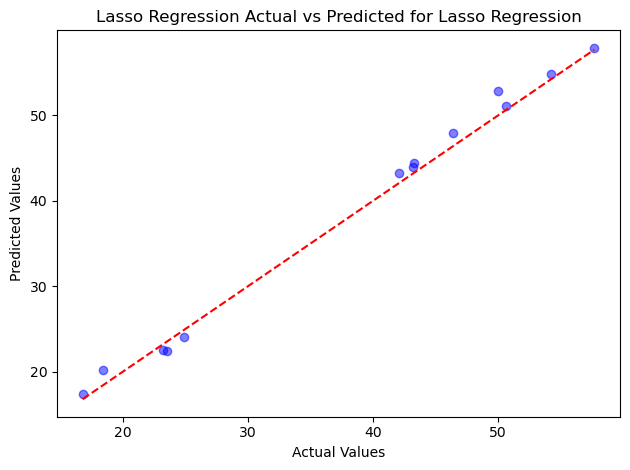

Actual vs. Prediction Chart for Population


None

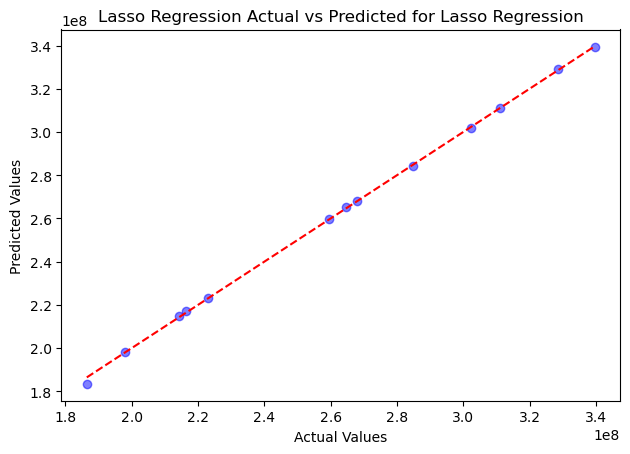

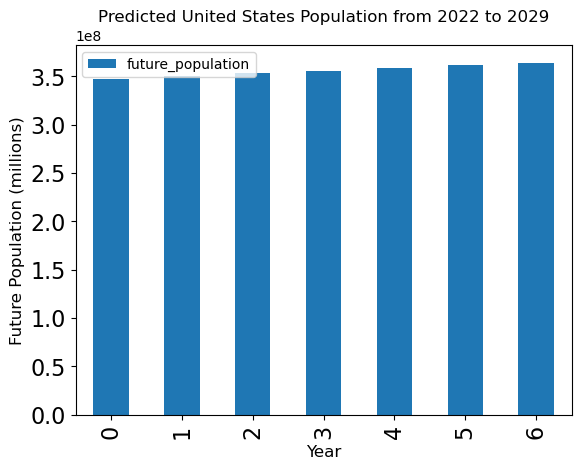

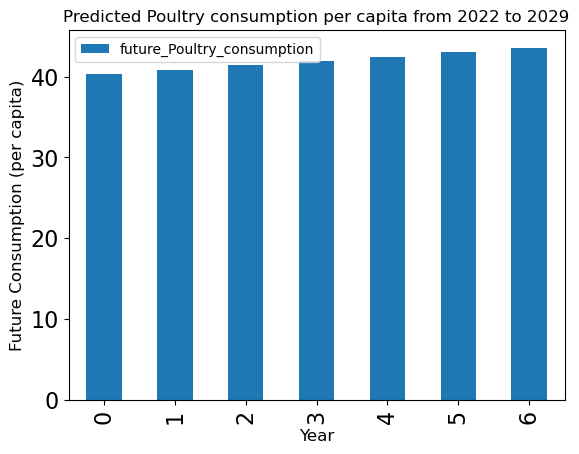

Population Predictions LassoRegression (millions)


None

['2022: 347134711.50',
 '2023: 349953220.89',
 '2024: 352771730.28',
 '2025: 355590239.67',
 '2026: 358408749.06',
 '2027: 361227258.45',
 '2028: 364045767.84']

Meat Consumption Predictions LassoRegression (kg per capita)


None

['2022: 40.27',
 '2023: 40.82',
 '2024: 41.37',
 '2025: 41.92',
 '2026: 42.48',
 '2027: 43.03',
 '2028: 43.58']

Population


None

{'mse': 939325704038.3065,
 'rmse': 969188.1675084083,
 'mae': 637854.4713961298,
 'r2': 0.999606124583141}

Meat Consumption


None

{'mse': 1.5521679736007725,
 'rmse': 1.2458603347088197,
 'mae': 1.0507453751867308,
 'r2': 0.9924860471678327}

In [37]:
ls_years, ls_pop_pred, ls_meat_pred, ls_metrics_pop, ls_metrics_meat = train_and_predict_lasso(filtered_population_df, country, 'Entity', 'population_historical', 'Year', meat_category, future_years)
combined_future_df = get_combined_future_df(ls_pop_pred,ls_meat_pred,future_X,meat_category)

display(print("Lasso Regression"))
display(print("Actual vs. Prediction Chart for Meat Consumption"))
plot_actual_vs_predicted("Lasso", plot_models['lasso_meat']['prediction'],plot_models['lasso_meat']['y_test'],"Lasso Regression")
display(print(f"Actual vs. Prediction Chart for Population"))
plot_actual_vs_predicted("Lasso",plot_models['lasso_population']['prediction'],plot_models['lasso_population']['y_test'],"Lasso Regression")
plot_population_prediction(combined_future_df,country,year_to_start_prediction,(year_to_start_prediction+future_years))
plot_meat_prediction(combined_future_df,meat_category,country,year_to_start_prediction,(year_to_start_prediction+future_years))
print_prediction(ls_years,ls_pop_pred, ls_meat_pred, ls_metrics_pop, ls_metrics_meat,"LassoRegression")


Ridge Regression

Ridge Regression


C:\Users\mark_\AppData\Local\Temp\ipykernel_26884\3824559344.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_entity_data.fillna(0, inplace=True)


None

Actual vs. Prediction Chart for Meat Consumption


None

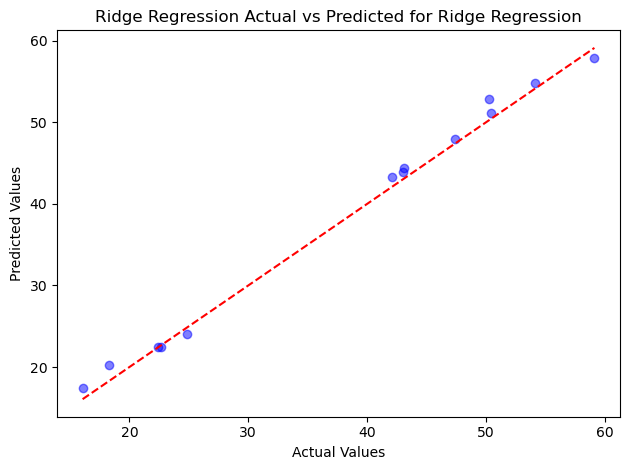

Actual vs. Prediction Chart for Population


None

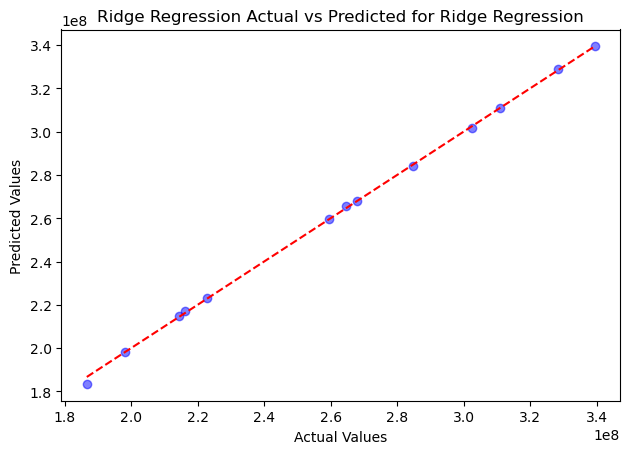

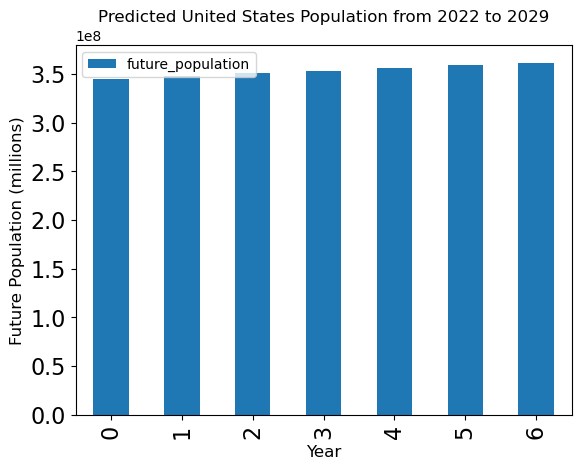

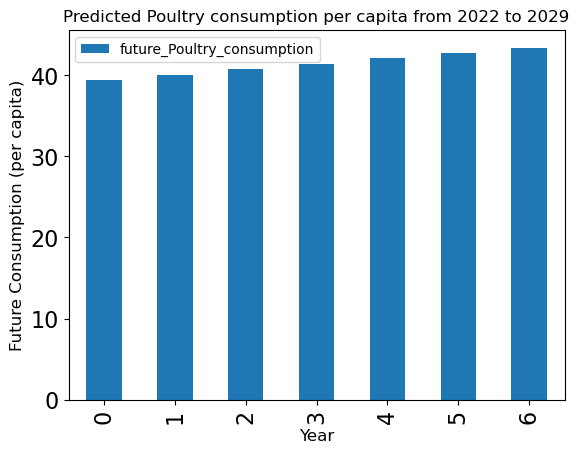

GradientCV Scores for Population


None

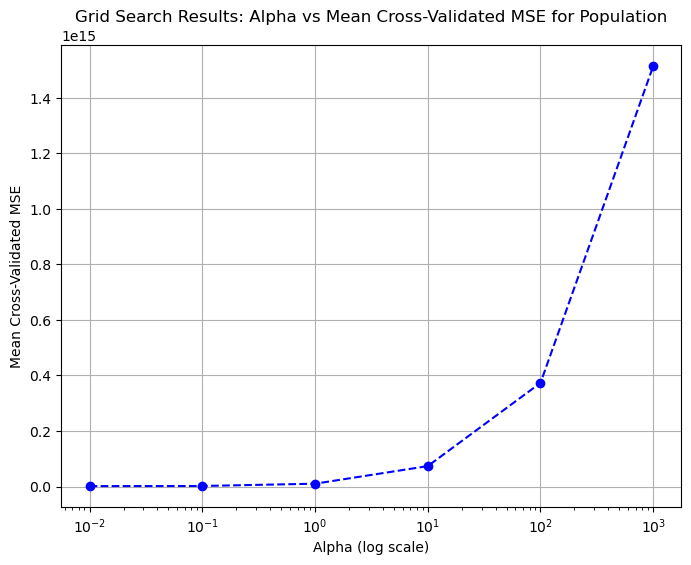

GradientCV Scores for Poultry consumption


None

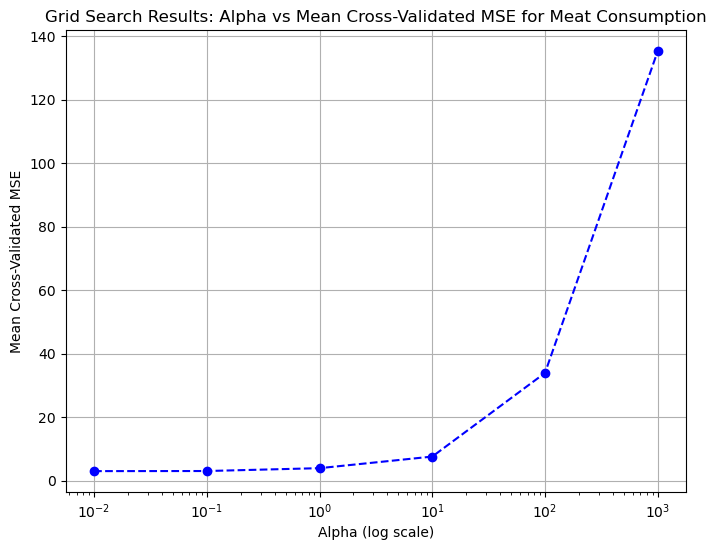

Population Predictions RidgeRegression (millions)


None

['2022: 345020955.73',
 '2023: 347793558.16',
 '2024: 350566160.59',
 '2025: 353338763.01',
 '2026: 356111365.44',
 '2027: 358883967.87',
 '2028: 361656570.30']

Meat Consumption Predictions RidgeRegression (kg per capita)


None

['2022: 39.42',
 '2023: 40.09',
 '2024: 40.76',
 '2025: 41.43',
 '2026: 42.09',
 '2027: 42.76',
 '2028: 43.43']

Population


None

{'mse': 1009965832798.7932,
 'rmse': 1004970.5631503806,
 'mae': 610769.957752833,
 'r2': 0.9995765039626865}

Meat Consumption


None

{'mse': 1.5270633220638241,
 'rmse': 1.235744035819645,
 'mae': 1.037489050183832,
 'r2': 0.9926075772926162}

In [38]:
r_years, r_pop_pred, r_meat_pred, r_metrics_pop, r_metrics_meat = train_and_predict_ridge(filtered_population_df, country, 'Entity', 'population_historical', 'Year', meat_category, future_years)
combined_future_df = get_combined_future_df(r_pop_pred,r_meat_pred,future_X,meat_category)
display(print("Ridge Regression"))
display(print("Actual vs. Prediction Chart for Meat Consumption"))
plot_actual_vs_predicted("Ridge", plot_models['ridge_meat']['prediction'],plot_models['ridge_meat']['y_test'],"Ridge Regression")
display(print(f"Actual vs. Prediction Chart for Population"))
plot_actual_vs_predicted("Ridge",plot_models['ridge_population']['prediction'],plot_models['ridge_population']['y_test'],"Ridge Regression")
plot_population_prediction(combined_future_df,country,year_to_start_prediction,(year_to_start_prediction+future_years))
plot_meat_prediction(combined_future_df,meat_category,country,year_to_start_prediction,(year_to_start_prediction+future_years))
best_matches = ridge_best_performance
display(print(f'GradientCV Scores for Population'))
plot_ridge_best_match(best_matches['population']['mean_scores'],best_matches['population']['alpha_values'],"Population")
display(print(f'GradientCV Scores for {meat_category} consumption'))
plot_ridge_best_match(best_matches['meat']['mean_scores'],best_matches['meat']['alpha_values'],"Meat Consumption")
print_prediction(r_years,r_pop_pred, r_meat_pred, r_metrics_pop, r_metrics_meat,"RidgeRegression")
                